In [1]:
!pip install plotly scikit-image scikit-learn

In [5]:
import zipfile
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import skimage as ski

In [7]:
path = "./data/images/*/*.png"
file_paths = sorted(glob(path))

In [8]:
type_to_file = []
for file_path in file_paths:
    parts = os.path.normcase(file_path).split(os.sep)
    type_name = parts[-2]
    file_name = parts[-1]
    type_to_file.append({"type": type_name, "file": file_name})

type_to_file[:5]

[{'type': 'bug', 'file': '010.png'},
 {'type': 'bug', 'file': '011.png'},
 {'type': 'bug', 'file': '012.png'},
 {'type': 'bug', 'file': '013.png'},
 {'type': 'bug', 'file': '014.png'}]

In [9]:
image_list = [ski.io.imread(filename) for filename in file_paths]

In [10]:
for i, img in enumerate(image_list):
    image_list[i] = ski.transform.resize(img, (128, 128, 4), preserve_range=True)

In [11]:
image_array = np.array(image_list, dtype=np.uint8)
image_array.shape

(1025, 128, 128, 4)

In [12]:
image_without_alpha_array = image_array[:, :, :, :3]
image_without_alpha_array.shape

(1025, 128, 128, 3)

In [13]:
image_without_alpha_flattened_array = image_without_alpha_array.reshape(image_without_alpha_array.shape[0], -1)
image_without_alpha_flattened_array.shape

(1025, 49152)

In [15]:
X = image_without_alpha_flattened_array

In [22]:
from sklearn.preprocessing import LabelEncoder

labels = [tf["type"] for tf in type_to_file]
le = LabelEncoder()
y = le.fit_transform(labels)
y.shape

(1025,)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=0
)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((512, 49152), (513, 49152), (512,), (513,))

In [17]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

In [18]:
pca = PCA(n_components=2, random_state=0)

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=0)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=4)

In [20]:
# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

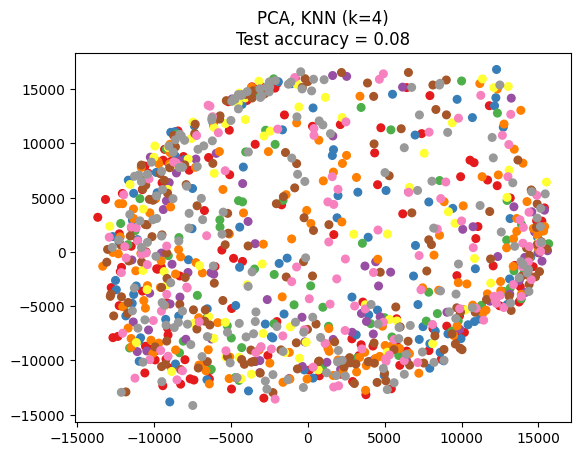

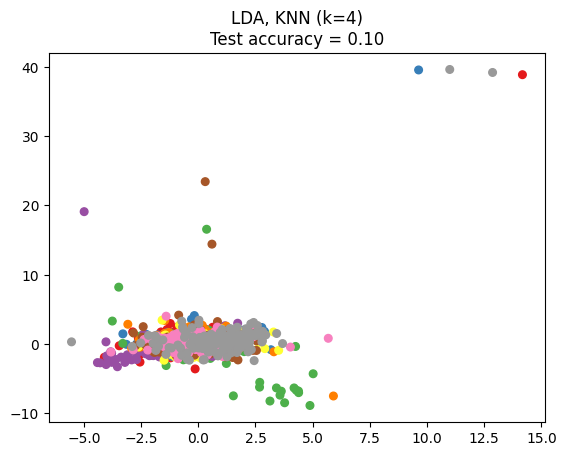

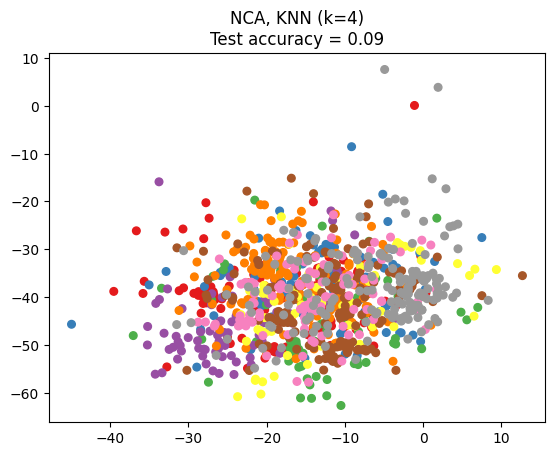

In [25]:
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, 4, acc_knn)
    )

plt.show()